#En esta lección desarrollaremos una red neuronal convolucional (CNN) para la detección de retinopatía diabética en imágenes médicas. 👁️👁️👩🏻‍⚕️👨🏻‍⚕️

Se desarrollará a partir de una metodología llamada "Transfer learning" (conjunto de métodos que permite transferir modelos preentrenados) evitando con ello grandes tiempos de cálculo y recursos.


###1. Para ello clasificaremos las diferentes etapas de retinopatía diabética:

* No_RD: No presenta Retinopatía Diabética (0).
* Mild: Retinopatía Diabética leve (1).
* Moderate: Retinopatía Diabética moderado (2).
* Severe: Retinopatía Diabética severo (3).
* Proliferate: Retinopatía Diabética proliferativa (4).

###2. Como dataset se utilizaron imágenes del fondo de retina de Kaggle: 📷
https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

* 1805 imágenes para la etapa No_RD.
* 370 imágenes para la etapa Mild.
* 999 imágenes para la etapa Moderate.
* 193 imágenes para la etapa Severe.
* 295 imágenes para la etapa Proliferate.

---

####PASO 1: IMPORTAMOS LAS LIBRERÍAS.

1. ImageDataGenerator: para generar imágenes mientras se entrena el modelo de CNN.
2. numpy: para realizar cálculos matemáticos sobre matrices.
3. matplotlib: para la creación de gráficos en dos dimensiones.
4. tensorflow: para construir y entrenar la red neuronal convolucional.
5. tensorflow_hub: contiene muchos modelos preentrenados uno de ellos es "mobilenet_v2/classification", este modelo fue entrenado con "ImageNet", el cual tiene 1000 distintas clases de imágenes.
6. cv2 opencv: para las transformaciones de imágenes.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

####PASO 2: NOS CONECTAMOS A GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####PASO 3: AUMENTO DE DATOS:
Generamos nuevas imágenes mientras se entrena el modelo de CNN, con ello indicamos que el 20% del total de imágenes será para realizar las pruebas.

In [ ]:
datagen = ImageDataGenerator(
    rescale=1. / 255, # normalizamos las imágenes (obteniendo el valor de pixeles desde 0 a 1).
    rotation_range = 10, # rota aleatoriamente las imágenes un máximo de 10° (-10 o 10).
    width_shift_range=0.15, # mover la imágen a la izquierda o derecha.
    height_shift_range = 0.15, # mover la imágen arriba o abajo.
    shear_range = 5, # deforma la imágen.
    zoom_range = [0.7, 1.3], # mínimo de acercamiento y alejamiento.
    validation_split = 0.2 # 20% de imágenes para pruebas.
)

data_gen_entrenamiento = datagen.flow_from_directory("/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/dataset_RD",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="training")

data_gen_pruebas = datagen.flow_from_directory("/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/dataset_RD",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="validation")


Found 2929 images belonging to 5 classes.
Found 729 images belonging to 5 classes.


Listamos el número de clases:

In [ ]:
list(data_gen_entrenamiento.class_indices.keys())

['0_No_DR', '1_Mild', '2_Moderate', '3_Severe', '4_Proliferate_DR']

In [ ]:
data_gen_entrenamiento.num_classes

5

####PASO 4: MOSTRAMOS CÓMO QUEDARON LAS IMÁGENES TRANSFORMADAS:

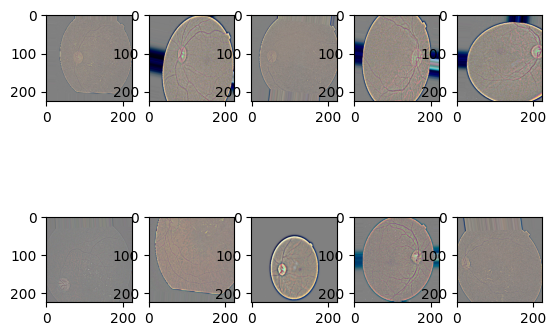

In [ ]:
for imagenes, etiquetas in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imagenes[i])

  break
plt.show()

####PASO 5: TRANSFERENCIA DE APRENDIZAJE:
Descargaremos de tensorflow_hub un modelo preentrenado por google el cual se entrenó con millones de imágenes y 1000 clases distintas.

* La siguiente url tiene a la CNN entrenada sin la última capa, ya que nosotros la agregaremos.

* KerasLayer: la usamos para descargar modelos preexistente.

In [ ]:
url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))

####PASO 6: CONGELAMIENTO DE CAPAS:
Este paso es muy importante en la transferencia de aprendizaje, ya que tomamos el modelo preentrenado "mobilenetv2" y evitamos que se vuelva a entrenar.

Asignandole "False" al modelo logramos el congelamiento de sus pesos y sesgos. Solo al final le agregamos una nueva capa que clasifique 5 opciones: No_RD, Mild, Moderate, Severe o Proliferate.


In [ ]:
mobilenetv2.trainable = False

####PASO 7: CREAMOS EL MODELO:

Estará conformado por el modelo preentrenado "mobilenet" y nuestra única capa densa.

mobilenet: su entrada es de 224x224x3 con una serie de capas convolucionales.

In [ ]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(data_gen_entrenamiento.num_classes, activation="softmax")
])

####PASO 8: COMPILAMOS EL MODELO


In [ ]:
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

####PASO 9: ENTRENAMOS EL MODELO

In [ ]:
EPOCAS = 20
entrenamiento = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/20
92/92 [==============================] - 194s 2s/step - loss: 0.9850 - accuracy: 0.6654 - val_loss: 0.8105 - val_accuracy: 0.7257
Epoch 2/20
92/92 [==============================] - 187s 2s/step - loss: 0.7895 - accuracy: 0.7183 - val_loss: 0.7501 - val_accuracy: 0.7243
Epoch 3/20
92/92 [==============================] - 189s 2s/step - loss: 0.7397 - accuracy: 0.7357 - val_loss: 0.7376 - val_accuracy: 0.7380
Epoch 4/20
92/92 [==============================] - 184s 2s/step - loss: 0.7052 - accuracy: 0.7494 - val_loss: 0.7011 - val_accuracy: 0.7462
Epoch 5/20
92/92 [==============================] - 189s 2s/step - loss: 0.7005 - accuracy: 0.7388 - val_loss: 0.6900 - val_accuracy: 0.7503
Epoch 6/20
92/92 [==============================] - 185s 2s/step - loss: 0.6833 - accuracy: 0.7491 - val_loss: 0.6769 - val_accuracy: 0.7517
Epoch 7/20
92/92 [==============================] - 184s 2s/step - loss: 0.6597 - accuracy: 0.7644 - val_loss: 0.6847 - val_accuracy: 0.7353
Epoch 8/20
92

####PASO 10: GRAFICAMOS
* accuracy, val_accuracy
* loss, val_loss

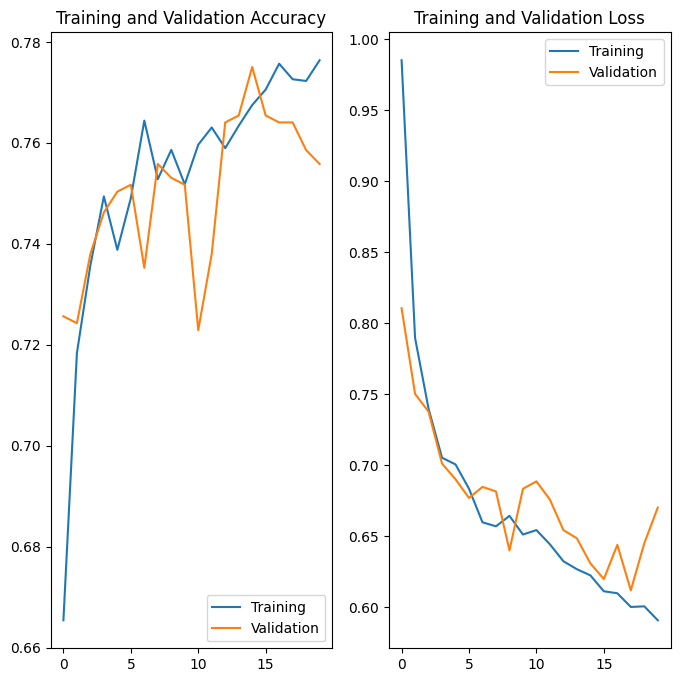

In [ ]:
acc = entrenamiento.history['accuracy']
val_acc = entrenamiento.history['val_accuracy']

loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

rango_epocas = range(20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Training')
plt.plot(rango_epocas, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Training')
plt.plot(rango_epocas, val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####PASO 11: FUNCIÓN CATEGORIZAR
Esta función recibirá la imágen que queremos predecir.

In [ ]:
from PIL import Image
import cv2

def categorizar(ruta):
  img = Image.open(ruta)
  img = img.convert("RGB")
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

####PASO 12: ENVIAMOS LAS IMÁGENES A PREDECIR
Le pasamos a la función categorizar las cinco etapas de Retinopatía Diabética:

* No_RD: No presenta Retinopatía Diabética (0).
* Mild: Retinopatía Diabética leve (1).
* Moderate: Retinopatía Diabética moderado (2).
* Severe: Retinopatía Diabética severo (3).
* Proliferate: Retinopatía Diabética (4).

####Imágen de fondo de retina: No_RD (0)

In [ ]:
ruta = "/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/No_RD.png"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 0s 51ms/step
0


####Imágen de fondo de retina: Mild (1)

In [ ]:
ruta = "/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/Mild.png"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 0s 50ms/step
1


####Imágen de fondo de retina: Moderate (2)

In [ ]:
ruta = "/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/Moderate.png"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 0s 51ms/step
2


####Imágen de fondo de retina: Severe (3)

In [ ]:
ruta = "/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/Severe.png"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 0s 52ms/step
2


####Imágen de fondo de retina: Proliferate (4)

In [ ]:
ruta = "/content/drive/MyDrive/GitHub Projects/Diabetic Retinopathy Detection/Proliferate.png"
prediccion = categorizar(ruta)
print(prediccion)

1/1 [==============================] - 0s 59ms/step
4


###CONCLUSIÓN: 👨🏻‍⚕️👩🏻‍⚕️👁️👁️

Las redes neuronales convolucionales (CNN) son muy usadas para clasificar imágenes, ya que los procesos de convolución y filtros ayudan a encontrar patrones.

Así mismo, el modelo dio como resultados:
1. loss: 0.5908
2. accuracy: 0.7764
3. val_loss: 0.6701
4. val_accuracy: 0.7558

En el paso 12 donde ingresamos imágenes para predecir, vemos que el modelo predijo para las etapas de retinopatía diabética 0, 1, 2 y 4, sin embargo para la etapa 3 no llegó a predecirlo.

Con ello se concluye que el modelo puede aún ser mejorado, el cual se espera realizarlo en un futuro no muy lejano.

Este proyecto se llevó a cabo gracias a los conocimientos impartidos de Rodrigo Montemayor en su curso de Introducción a Inteligencia Artificial.



---

